In [1]:
import csv 
import shapefile
import time
import sys

from math import radians
from math import sin, cos, sqrt, atan2 # approximate radius of earth in meters
from gurobipy import *
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
#from descartes import PolygonPatch
#from shapely.geometry import Polygon, mapping
from shapely.geometry.multipolygon import MultiPolygon
from shapely import wkt

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# Preprocess 
    gdf | edf | vdf | odf | edgetuple

In [2]:
def read_geo_file(file_name = 'OriginalDataBaseFile/RealPropertiesExtraClean.csv'):
    """ 
    read file from csv and return geodataframe
    """
    df = pd.read_csv(file_name) 
    df.rename(columns={"Parcel":"geometry"},inplace=True)
    df.geometry = df.geometry.apply(lambda var: MultiPolygon([wkt.loads(var)])) # string to multipolygon

    gdf = gpd.GeoDataFrame(df)
    gdf["Block"] = gdf.BlockLot.apply(lambda num: num[:4])
    gdf.crs = {'init' :'epsg:4326'}
    
    gdf['x'] = gdf.geometry.centroid.x # Longitude
    gdf['xradians'] = gdf.x.apply(radians) # x coords to radians
    gdf['y'] = gdf.geometry.centroid.y # Latitude
    gdf['yradians'] = gdf.y.apply(radians) # y coords to radians
    gdf['yx'] = zip(gdf.y,gdf.x) # (lat, lon)
    
    # for optimization computation
    gdf['xyradians'] = zip(gdf.xradians,gdf.yradians)
    gdf['xyrID'] = zip(gdf.xyradians,gdf.ID)
    
    return gdf


In [3]:
class preprocess_data(object):
    def __init__(self,gdf,edf):
        
        self.gdf = gdf
        self.edf = edf
        self.target_building_size()
        self.get_house_subset()
        self.ogdf, self.vgdf = self.get_house_subset()
        self.info()
        
    def target_building_size(self,lower = 3e-09, upper = 5e-08, inplace = True):
        """ 
        return sub-gdf with gdf.geometry.area in (lower, upper)
        if inplace = True, update edf also
        """
        if not inplace:
            return self.gdf[(self.gdf.geometry.area> lower) & (self.gdf.geometry.area< upper) ] 
        
        self.gdf = self.gdf[(self.gdf.geometry.area> lower) & (self.gdf.geometry.area< upper) ] 
        self.edf = self.edf[(self.edf.aID.isin(set(self.gdf.ID))) 
                          & (self.edf.bID.isin(set(self.gdf.ID)))]
    
    def get_house_subset(self):
        ogdf = self.gdf[self.gdf.IsVacant == 0]
        vgdf = self.gdf[self.gdf.IsVacant == 1]
        return ogdf, vgdf
    
    def info(self):
        print "total:", len(self.gdf)
        print "residents:" ,len(self.ogdf)
        print "vacant:", len(self.vgdf)
        print "edges:", len(self.edf)

In [4]:
"""
Read and Preprocess data
# Note: skip the last row in edge csv 
"""
data = preprocess_data(read_geo_file(), pd.read_csv('OriginalDataBaseFile/RealGoodNeighbors.csv',low_memory=False,
                                   skiprows = lambda x: x == 137240 ) )

gdf, ogdf, vgdf, edf = data.gdf, data.ogdf, data.vgdf, data.edf
edgetuple = zip(edf.aID,edf.bID)

total: 176474
residents: 160748
vacant: 15726
edges: 132489


# Setup Basic Constraint and Write Model in mps( Before Budget Constraint )

In [5]:
##################################################
##
##                Model list
##
##################################################

#uppers = [10,20,40,160,300,400,500,550,600]
#powers = [0,1,2,3,4]
#uppers = [200]
#powers = [0,1,2,3,4]
#uppers = [100]
#powers = [0,1,2,3,4]

In [6]:
def real_dis_affect(col,col2,power = 1, upper = 500):
    lon1, lat1 = col
    lon2, lat2 = col2
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    dis = R * c*1000 
    
    return 1.0/(dis**power) if dis < upper else 0

In [7]:
for upper in uppers:
    for power in powers:
        model = Model() 
        model.Params.Threads = 4 # parallel

        x = model.addVars(gdf.ID,vtype = GRB.BINARY,name = "x")
        y = model.addVars(edgetuple,vtype = GRB.BINARY,name = "y")
        bigM = model.addVars(vgdf.ID,vtype = GRB.CONTINUOUS,name = "bigM",lb = -GRB.INFINITY, ub = 0.0)
        model.update()


        # y_{ij} = x_i and x_j
        and1 = model.addConstrs((x[edgetuple[i][1]] + x[edgetuple[i][0]] - y[edgetuple[i]] <= 1 
                              for i in xrange(len(edgetuple))
                             ),name = "and1")

        and2 = model.addConstrs((-x[edgetuple[i][1]]  + y[edgetuple[i]] <= 0 
                              for i in xrange(len(edgetuple))
                             ),name = "and2")

        and3 = model.addConstrs((-x[edgetuple[i][0]]  + y[edgetuple[i]] <= 0 
                              for i in xrange(len(edgetuple))
                             ),name = "and3")


        # big M Constraint
        s = time.time()
        for h in xrange(len(vgdf)):
            model.addConstr(
                ( bigM[vgdf.ID.iloc[h]] <= 
                  quicksum( ogdf[((ogdf.xradians <= vgdf.xradians.iloc[h] + 0.00012) & 
        (ogdf.xradians >= vgdf.xradians.iloc[h] - 0.00012) &
        (ogdf.yradians <= vgdf.yradians.iloc[h] + 0.0001) & 
        (ogdf.yradians >= vgdf.yradians.iloc[h] - 0.0001) )].xyrID.apply(lambda var: real_dis_affect(var[0],vgdf.xyradians.iloc[h],power,upper)*(x[var[1]]-1)) )
                  + 200000.0*x[vgdf.ID.iloc[h]] 
                ), name = "occupied"+str(h) ) 

            if (h+1)%10 == 0:
                sys.stdout.write(str(h+1)+"/" +str(len(vgdf))+ " files , time: "+str(time.time()-s)+'\r')
                sys.stdout.flush()
        print "total time: ", round(time.time()-s,3) , " sec"


        model.write('model/model-d%s-p%s.lp' %(upper,power))
        model.write('model/model-d%s-p%s.mps'%(upper,power))
        model.write('model/model-d%s-p%s.prm'%(upper,power))

Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
total time:  2219.845 me: 2219.21167994 sec
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
total time:  2118.367  sec2117.55478191
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
total time:  1912.681  sec1912.13697505
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
total time:  1761.11  sec 1760.00862098
Changed value of parameter Threads to 4
   Prev: 0  Min: 0  Max: 1024  Default: 0
total time:  2028.711  sec2027.94407487


# Read MPS

In [7]:
def read_model(model_name = 'model-02-04-18-d500'):
    
    model = read(model_name + '.mps')
    model.read(model_name + '.prm')
    # bigM method
    bigM = tupledict()
    # neighbors
    y = tupledict()
    # houese
    x = tupledict()
    
    for var in model.getVars():
        if var.VarName[:1] == "x":
            x[int(var.VarName[2:-1])] = var
        elif var.VarName[:1] == "y":
            y[tuple(map(int,var.VarName[2:-1].split(",")))] = var
        if var.VarName[:4] == "bigM":
            bigM[int(var.VarName[5:-1])] = var
            
    return model, x, y, bigM

In [12]:
"""
test area
set up final stage linear constraints (Gurobi)
"""
# default value
Budget = 500000
demolish_2_story, demolish_3_story = 13000, 22000
r_relocate, o_relocate = 85000, 170000
wall_2_story, wall_3_story = 14000, 25000
cost_reduction = 2000

# cost list
Cost = [ 13000 + (85000 if gdf.loc[i,"IsVacant"]== 0 else 0) for i in gdf.index ]
Benefit = [ cost_reduction for i in xrange(len(edf))]
wi = [ 14000 for i in xrange(len(edf))] # 01-10-18
wj = [ 14000 for i in xrange(len(edf))]


Budget_Constraint = model.addConstr((quicksum(Cost[i]*x[gdf.ID.iloc[i]] for i in xrange(len(gdf))) -
                     quicksum((Benefit[i]+wi[i]+wj[i])*y[edgetuple[i]] for i in xrange(len(edgetuple))) +
                     quicksum(wi[i]*x[edgetuple[i][1]] for i in xrange(len(edgetuple))) +
                     quicksum(wj[i]*x[edgetuple[i][0]] for i in xrange(len(edgetuple))) 
                     <= 
                     Budget 
                    )
                     , name = "Budget_Constraint")

# set objective
model.setObjective( quicksum(bigM[i] for i in vgdf.ID), GRB.MAXIMIZE)

# Setup and Final Constraint ( Budget Constraint )

In [11]:
class LPSolve(object):
    def __init__(self, model = None, x = None, y = None, bigM = None, early = True):
        if model != None:
            self.model = model
            self.x = x
            self.y = y
            self.bigM = bigM
        else:
            self.model, self.x, self.y, self.bigM = read_model()
        self.solcounts = 0
        self.status = []
        
            
    def budget_constraint(self,
                          Budget = 5000000,
                          demolish_2_story = 13000, demolish_3_story = 22000,
                          r_relocate = 85000, o_relocate = 170000,
                          wall_2_story = 14000, wall_3_story = 25000,
                          cost_reduction = 0):
        
        # cost list
        Cost = [ 13000 + (85000 if gdf.loc[i,"IsVacant"]== 0 else 0) for i in gdf.index ]
        Benefit = [ cost_reduction for i in xrange(len(edf))]
        wi = [ 14000 for i in xrange(len(edf))] # 01-10-18
        wj = [ 14000 for i in xrange(len(edf))]

    
        Budget_Constraint = self.model.addConstr((quicksum(Cost[i]*self.x[gdf.ID.iloc[i]] for i in xrange(len(gdf))) -
                     quicksum((Benefit[i]+wi[i]+wj[i])*self.y[edgetuple[i]] for i in xrange(len(edgetuple))) +
                     quicksum(wi[i]*self.x[edgetuple[i][1]] for i in xrange(len(edgetuple))) +
                     quicksum(wj[i]*self.x[edgetuple[i][0]] for i in xrange(len(edgetuple))) 
                     <= 
                     Budget 
                    )
                     , name = "Budget_Constraint")
        
        # save into clase which we can check later
        self.Budget = Budget
        self.demolish_2_story, self.demolish_3_story = demolish_2_story, demolish_3_story
        self.r_relocate, self.o_relocate = r_relocate, o_relocate
        self.wall_2_story, self.wall_3_story = wall_2_story, wall_3_story
        self.cost_reduction = cost_reduction
        
        # for update status
        self.Cost = [ 13000 + (85000 if gdf.loc[i,"IsVacant"]== 0 else 0) for i in gdf.index ]
        self.Benefit = [ cost_reduction for i in xrange(len(edf))]
        self.wi = [ 14000 for i in xrange(len(edf))] # 01-10-18
        self.wj = [ 14000 for i in xrange(len(edf))]
        
        self.model.setObjective( quicksum(self.bigM[i] for i in vgdf.ID), GRB.MAXIMIZE)
        
    def set_objective(self):
        pass
        self.model.setObjective( quicksum(self.bigM[i] for i in vgdf.ID), GRB.MAXIMIZE)
    
    def solve(self):
        
        if self.solcounts == 0:
            pass
    
        elif sum(self.x[gdf.ID.iloc[i]].X for i in xrange(len(gdf))) != 0:
            self.model.addConstr(
                (
                quicksum(self.x[gdf.ID.iloc[i]] 
                         if self.x[gdf.ID.iloc[i]].X == 1 or abs(self.x[gdf.ID.iloc[i]].X - 1.0) < 0.000001 
                         else 0 for i in xrange(len(gdf)))
                <= sum( 1
                       if self.x[gdf.ID.iloc[i]].X == 1 or abs(self.x[gdf.ID.iloc[i]].X - 1.0) < 0.000001 
                       else 0 for i in xrange(len(gdf)))-1
                ),name = 'temp'
            )

        self.model.optimize()
        self.solcounts += 1
        
        self.update_status()
        
    def update_status(self):
        spent = (sum(self.Cost[i]*self.x[gdf.ID.iloc[i]].X for i in xrange(len(gdf))) -
                 sum((self.Benefit[i]+self.wi[i]+self.wj[i])*self.y[edgetuple[i]].X for i in xrange(len(edgetuple))) +
                 sum(self.wi[i]*self.x[edgetuple[i][1]].X for i in xrange(len(edgetuple))) +
                 sum(self.wj[i]*self.x[edgetuple[i][0]].X for i in xrange(len(edgetuple))) )


        num_houses = sum(self.x[i].X  for i in gdf.ID)

        #print "Budget : %s   number of houses : %s" %(spent, num_houses)
        print("Budget : %s   number of houses : %s   ObjVal : %s   Running Time : %s" %
               (spent,num_houses,self.model.ObjVal,self.model.Runtime))
        self.status.append((spent,num_houses,self.model.ObjVal,self.model.Runtime))
    
    def get_status(self):
        try:
            return ("Budget : %s   number of houses : %s   ObjVal : %s   Running Time : %s" %
                        self.status[-1])
        except:
            print "please calling self.solve() before calling self.get_status" 

# Quick Example

In [12]:
rmodel, rx, ry, rbigM= read_model("model/model-d550-p2")
solver = LPSolve(rmodel,rx,ry,rbigM)
solver.budget_constraint()
solver.solve()

Set parameter Threads to value 4
Read parameters from file model/model-d550-p2.prm
Optimize a model with 413194 rows, 324689 columns and 32188542 nonzeros
Variable types: 15726 continuous, 308963 integer (308963 binary)
Coefficient statistics:
  Matrix range     [3e-06, 2e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 5e+06]
Found heuristic solution: objective -1984.23
Presolve removed 0 rows and 1561 columns (presolve time = 10s) ...
Presolve removed 0 rows and 2756 columns (presolve time = 16s) ...
Presolve removed 0 rows and 2756 columns (presolve time = 20s) ...
Presolve removed 0 rows and 2756 columns (presolve time = 25s) ...
Presolve removed 0 rows and 2756 columns (presolve time = 30s) ...
Presolve removed 2919 rows and 4169 columns (presolve time = 37s) ...
Presolve removed 2919 rows and 4169 columns (presolve time = 42s) ...
Presolve removed 2919 rows and 4579 columns (presolve time = 46s) ...
Presolve removed 3739 rows and

In [13]:
solver.status

[(4990000.0, 288.0, -1930.9828213850424, 210.63547611236572)]

In [15]:
solver.get_status()

'Budget : 4990000.0   number of houses : 288.0   ObjVal : -1930.98282139   Running Time : 210.635476112'

# Footprint Groupby Block

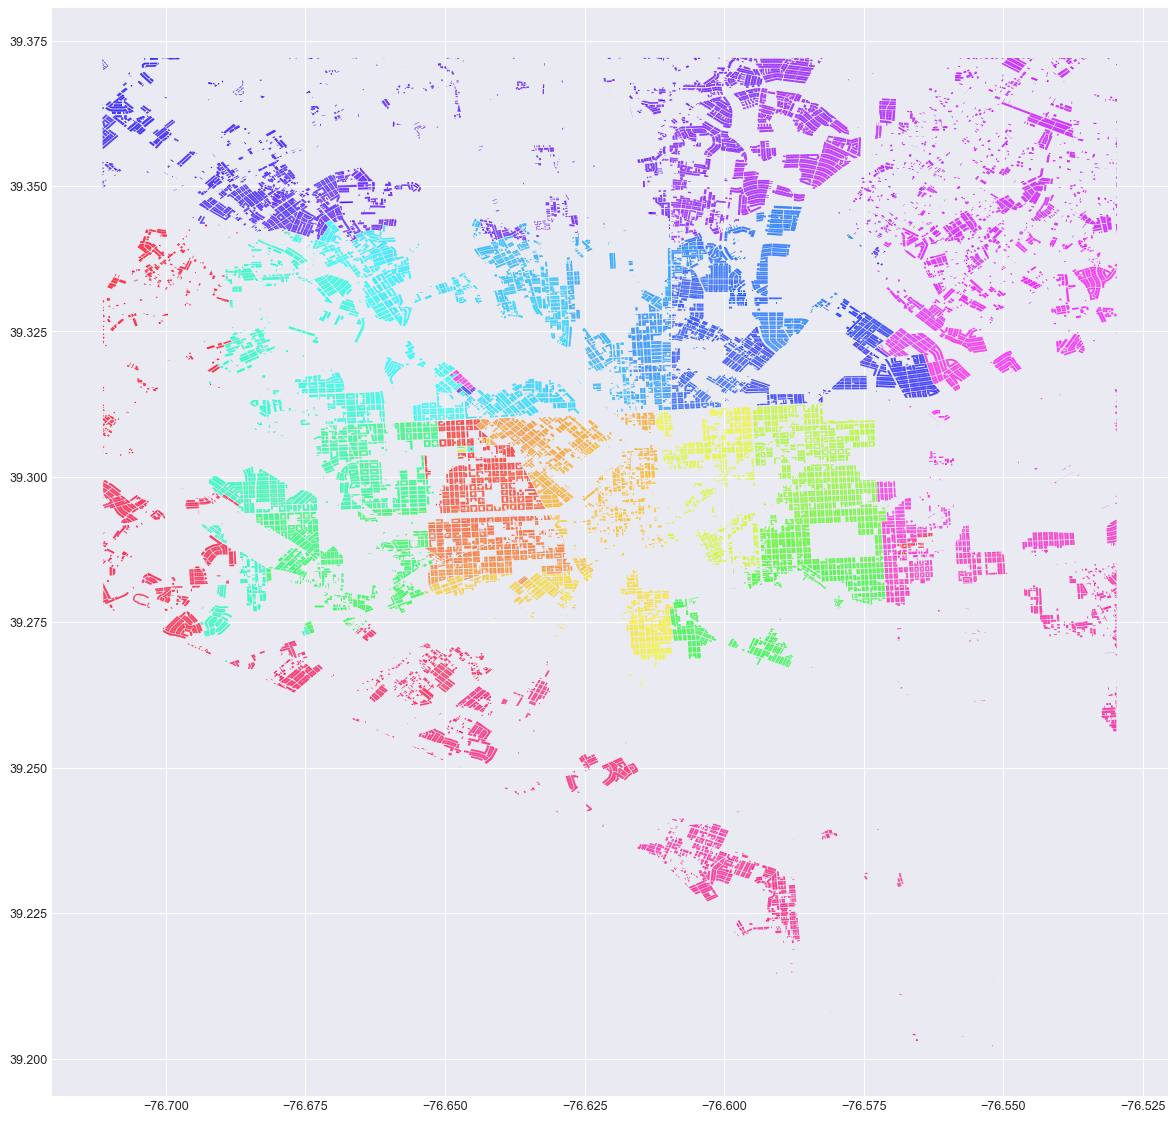

In [116]:
fig = plt.figure(1, figsize=(16,16), dpi=90)
ax = fig.add_subplot(111)

gdf.plot(ax = ax,color = gdf.Block, cmap = "hsv")